# Cloning The Repo

In [5]:
! git clone https://github.com/ztuntrade/untrade-sdk.git && cd untrade-sdk

Cloning into 'untrade-sdk'...


# Importing the Lib

In [3]:
import time
import pandas as pd
import pandas_ta as ta
import talib as t
from tqdm import tqdm
import numpy as np
from untrade.client import Client
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
import talib as t
import warnings
warnings.filterwarnings('ignore')

# Code Base

100%|██████████| 125/125 [00:00<00:00, 1078.23it/s]


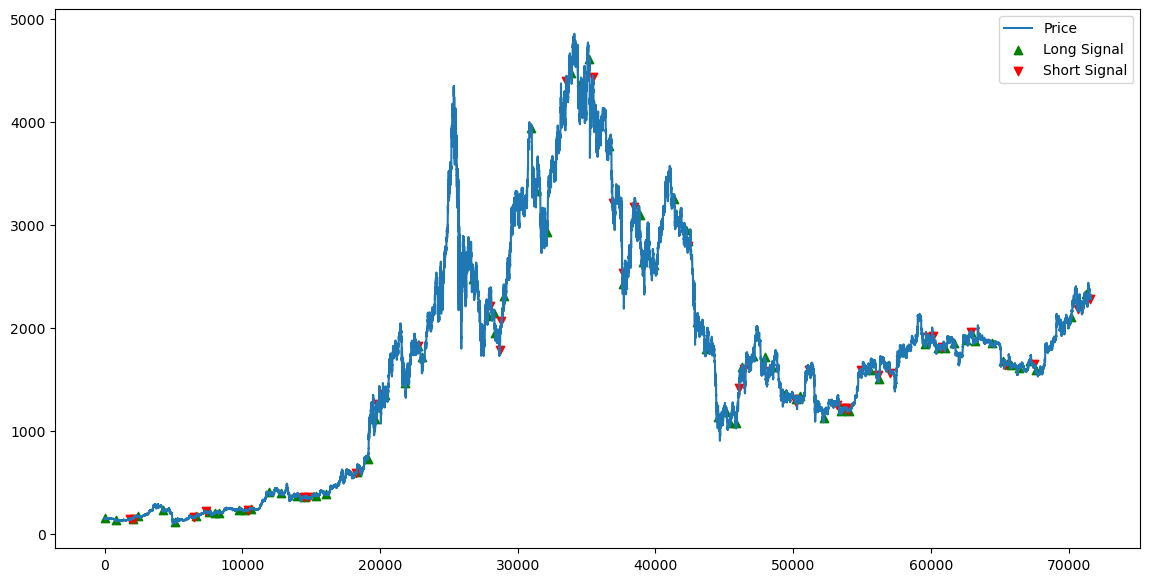

pnl : 3691.6842669691528
n_trades: 126
Max_dd_s: 15.81479038718533
Max_dd_comp 57.64515804454787
Max_dd_trade 84


In [4]:
class PnlCalculator:
    def __init__(self, look_back_days, adx_threshold, exit_threshold, atr_multiplier):
        self.look_back_days = look_back_days
        self.adx_threshold = adx_threshold
        self.exit_threshold = exit_threshold
        self.atr_multiplier = atr_multiplier

    def Crossover(self):
        start_time = time.time()

        df = pd.read_csv("ETHUSDT_30m.csv") #Importing coin data(replace file name with local file name)
        df = df.rename(columns={'datetime': 'timestamp'})

        #Core Signal Generations
        df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
        df['HA_Open'] = (df['open'] + df['close']) / 2
        df['HA_Open'] = df['HA_Open'].shift(1)
        df['HA_Open'].iloc[0] = df['open'].iloc[0]
        df['HA_High'] = df[['HA_Open', 'HA_Close']].join(df['high']).max(axis=1)
        df['HA_Low'] = df[['HA_Open', 'HA_Close']].join(df['low']).min(axis=1)

        df['ATR'] = ta.atr(df.HA_High, df.HA_Low, df.HA_Close, window=14)
        df['adx'] = t.ADX(df['HA_High'], df['HA_Low'], df['HA_Close'], timeperiod=self.look_back_days)
        df['+di'] = t.PLUS_DI(df['HA_High'], df['HA_Low'], df['HA_Close'], timeperiod=15)
        df['-di'] = t.MINUS_DI(df['HA_High'], df['HA_Low'], df['HA_Close'], timeperiod=15)
        df['rsi'] = t.RSI(df['HA_Close'], timeperiod=14)
        df['MACD'], df['MACD_signal'], df['MACD_hist'] = t.MACD(df['HA_Close'], fastperiod=12, slowperiod=26, signalperiod=9)

        df['MA_Short'] = ta.sma(df['HA_Close'], length=5)
        df['MA_Long'] = ta.sma(df['HA_Close'], length=20)

        df['HA_Green'] = df['HA_Close'] > df['HA_Open']
        df['HA_Red'] = df['HA_Close'] < df['HA_Open']

        df['Signal_Long'] = (df['HA_Green'] & df['HA_Green'].shift(1)) & (df['adx'] > self.adx_threshold) & (df['adx'].shift(1) < self.adx_threshold)
        df['Signal_Short'] = (df['HA_Red']& df['HA_Red'].shift(1)) & (df['MA_Short'] > df['MA_Long']) & (df['adx'] > self.adx_threshold) & (df['adx'].shift(1) < self.adx_threshold)

        df['signals'] = df.apply(lambda x: 1 if x['Signal_Long'] else 2 if x['Signal_Short'] else 0, axis=1)
        df['signals'] = df.apply(lambda row: row['signals'] if (row['rsi'] < 70)  else 0, axis=1)

    

        in_trade_long, in_trade_short = False, False
        df['remarks'] = 'Algo_Exit'

        for i in tqdm(range(len(df))):
            if df['signals'].iloc[i - 1] == -1:
                df.at[i, 'signals'] = 2
                in_trade_short = True
            if df['signals'].iloc[i - 1] == -2:
                df.at[i, 'signals'] = 1
                in_trade_long = True
            elif df['signals'].iloc[i] == 2 and in_trade_long:
                df.at[i, 'signals'] = -1
                in_trade_long = False
            elif df['signals'].iloc[i] == 1 and in_trade_short:
                df.at[i, 'signals'] = -2
                in_trade_short = False
            elif df['signals'].iloc[i] == 2 and not in_trade_short:
                in_trade_short = True
                in_trade_long = False
            elif df['signals'].iloc[i] == 1 and not in_trade_long:
                in_trade_long = True
                in_trade_short = False

        sl, entry_price, target_points = 0, 0, 0
        trailing_sl, intrade_long, intrade_short = 0, False, False
        max_drawdown_reached = False
        cumulative_profit = 0

        
        for i in tqdm(range(len(df))):
            
            if df['signals'].iloc[i] == 1:
                entry_price = df["HA_Close"].iloc[i]
                sl = df["HA_Close"].iloc[i] - self.atr_multiplier * df['ATR'].iloc[i]
                trailing_sl = entry_price - self.atr_multiplier * df['ATR'].iloc[i]
                intrade_long = True
                target_points = 60 * df['ATR'].iloc[i]
            elif df['signals'].iloc[i] == 2:
                entry_price = df["HA_Close"].iloc[i]
                sl = df["HA_Close"].iloc[i] + self.atr_multiplier * df['ATR'].iloc[i]
                trailing_sl = entry_price + self.atr_multiplier * df['ATR'].iloc[i]
                intrade_short = True
                target_points = 2 * df['ATR'].iloc[i]
            elif intrade_short:
                if df['HA_Close'].iloc[i] < entry_price - target_points or df['adx'].iloc[i] > self.exit_threshold or df['HA_Close'].iloc[i] > sl:
                    df['signals'].iloc[i] = -2
                    df['remarks'].iloc[i] = 'SL_Exit'
                    intrade_short = False
                else:
                    trailing_sl = min(trailing_sl, df['HA_Close'].iloc[i] + self.atr_multiplier * df['ATR'].iloc[i])
                    if df['HA_Close'].iloc[i] >= trailing_sl:
                        df['signals'].iloc[i] = -2
                        df['remarks'].iloc[i] = 'Trailing_SL_Exit'
                        intrade_short = False
            elif intrade_long:
                if df['HA_Close'].iloc[i] > entry_price + target_points or df['adx'].iloc[i] > self.exit_threshold or df['HA_Close'].iloc[i] < sl:
                    df['signals'].iloc[i] = -1
                    df['remarks'].iloc[i] = 'SL_Exit'
                    intrade_long = False
                else:
                    trailing_sl = max(trailing_sl, df['HA_Close'].iloc[i] - self.atr_multiplier * df['ATR'].iloc[i])
                    if df['HA_Close'].iloc[i] <= trailing_sl:
                        df['signals'].iloc[i] = -1
                        df['remarks'].iloc[i] = 'Trailing_SL_Exit'
                        intrade_long = False

        df_1 = df
        long_open = False
        short_open = False

        for index, row in df_1.iterrows():
            signal = row['signals']

            if signal == 2 and short_open:
                df_1.at[index, 'signals'] = 0
            elif signal == 1 and long_open:
                df_1.at[index, 'signals'] = 0
            elif signal == 1 and long_open != True:
                long_open = True
            elif signal == 2 and short_open != True:
                short_open = True

            elif signal == -1:
                if long_open:
                    long_open = False
                else:
                    df_1.at[index, 'signals'] = 0
            elif signal == -2:
                if short_open:
                    short_open = False
                else:
                    df_1.at[index, 'signals'] = 0


                    ####END OF SIGNAL GENERATION#####

        ###BACKTESTING#####

        df_1['signal'] = df_1['signals']
        df_1.to_csv('signals.csv')
        dg = df_1[df_1['signal'] != 0]
        

        dg['entry_price'] = dg['close']
        dg['entry_timestamp'] = dg['timestamp']
        dg['exit_price'] = dg['entry_price'].shift(-1)
        dg['exit_timestamp'] = dg['timestamp'].shift(-1)
        pnl = dg[dg['signal'] > 0][['entry_timestamp', 'entry_price', 'exit_timestamp', 'exit_price', 'signal', 'remarks']]


        ##for static statistics

        pnl['profit_per_btc'] = np.where(pnl['signal'] == 1, pnl['exit_price'] - pnl['entry_price'], 
                                        np.where(pnl['signal'] == 2, pnl['entry_price'] - pnl['exit_price'], None)) 
        pnl['capital'] = 1000
        pnl['#units'] = pnl['capital'] / pnl['entry_price']
        pnl['profit_per_capital'] = pnl['#units'] * pnl['profit_per_btc']
        pnl['tnc_cost'] = 1.5
        pnl['profit_after_tnc'] = pnl['profit_per_capital'] - pnl['tnc_cost']
        pnl['cumulative_profit'] = pnl['profit_after_tnc'].cumsum()
        pnl['roe_%'] = (pnl['profit_after_tnc'] / pnl['capital']) * 100
        net_pnl = pnl.reset_index()
        n_trades = pnl.shape[0]
        pnl['c_f'] = pnl['cumulative_profit'] + 1000
        peak = 1000
        max_drawdown = 0
        for value in pnl['c_f']:
            if value > peak:
                peak = value
            drawdown = (peak - value) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown

        max_drawdown_percentage_static = max_drawdown * 100

        ##for compounding statistics
        d = dg[dg['signal'] > 0][['entry_timestamp', 'entry_price', 'exit_timestamp', 'exit_price', 'signal']]
        d['profit_per_eth'] = np.where(d['signal'] == 1, d['exit_price'] - d['entry_price'], 
                                                 np.where(d['signal'] == 2, d['entry_price'] - d['exit_price'], None))
        d['tnc_cost'] = 1.5
        d['capital'] = 1000
        d['units'] = 1000 / d['entry_price']
        d['profit_per_capital'] = d['units'] * d['profit_per_eth']
        d['profit_after_tnc'] = d['profit_per_capital'] - d['tnc_cost']
        #d['cumulative_profit'] = 0
        
        for i in tqdm(range(1, len(d))):
            d['capital'].iloc[i] = d['capital'].iloc[i - 1] + d['profit_after_tnc'].iloc[i - 1]
            d['capital'].iloc[i]/=1.0015
            d['units'].iloc[i] = d['capital'].iloc[i] / d['entry_price'].iloc[i]
            d['profit_per_capital'].iloc[i] = d['units'].iloc[i] * d['profit_per_eth'].iloc[i]
            d['profit_after_tnc'].iloc[i] = d['profit_per_capital'].iloc[i] - d['tnc_cost'].iloc[i]
            #d['cumulative_profit'].iloc[i] = d['capital'].iloc[i-1] + d['cumulative_profit'].iloc[i] + d['profit_after_tnc'].iloc[i]

        d['c_f'] = d['capital']
        peak = 1000
        max_drawdown = 0
        max_dd_trade_time = 0
        max_dd_index = 0 

        for i, value in enumerate(d['c_f']):
            if value > peak:
                peak = value
            drawdown = (peak - value) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown
                max_dd_index = i

        max_drawdown_percentage_compounding = max_drawdown * 100

        end_time = time.time()
        time_taken = end_time - start_time


        ##visualising signals
        plt.figure(figsize=(14, 7))
        plt.plot(df['close'], label='Price')
        plt.scatter(df[df['signals'] == 1].index, df[df['signals'] == 1]['close'], marker='^', color='g', label='Long Signal', alpha=1)
        plt.scatter(df[df['signals'] == 2].index, df[df['signals'] == 2]['close'], marker='v', color='r', label='Short Signal', alpha=1)
        plt.legend()
        plt.show()

        return net_pnl, net_pnl['profit_after_tnc'].sum(), time_taken, max_drawdown_percentage_static, n_trades, max_drawdown_percentage_compounding, max_dd_index 

if __name__ == "__main__":
    pnl_calculator = PnlCalculator(
        look_back_days=11, 
        adx_threshold=30, 
        exit_threshold=86, 
        atr_multiplier=15)  # Create an instance of PnlCalculator 
    obj, net_pnl_amount, time_taken, max_drawdown_percentage_static, n_trades, max_drawdown_percentage_compounding, max_dd_index = pnl_calculator.Crossover()

    obj.to_csv('pnl_since_2019.csv', index=False)
    
    print("pnl :", net_pnl_amount)
    print("n_trades:", n_trades)
    print("Max_dd_s:", max_drawdown_percentage_static)
    print("Max_dd_comp", max_drawdown_percentage_compounding)
    print("Max_dd_trade", max_dd_index)


# Backtesting Using The SDK 

In [5]:
def strat(data):
    dg = data
    for i in tqdm(range(len(dg))):
        if dg['signals'].iloc[i] == 2 :
            dg['signals'].iloc[i] = -1
        elif dg['signals'].iloc[i] == -2 :
            dg['signals'].iloc[i] = 1
    return dg

In [6]:
def perform_backtest(csv_file_path):
    client = Client()

    # Perform backtest using the provided CSV file path
    result = client.backtest(
        jupyter_id="kchitizraj",  # the one you use to login to jupyter.untrade.io
        file_path=csv_file_path,
        leverage=1,# Adjust leverage as needed
    )
    return result

In [7]:
import pandas as pd
if __name__ == "__main__":
    # Read data from CSV file
    data = pd.read_csv("signals.csv")
    data = data[data["signals"]!=0]
    data = data.rename(columns={'timestamp': 'datetime'})
    res1 = strat(data)
    res = (res1)
    res.to_csv("processed_data.csv", index=False)

    # Perform backtest on processed data
    csv_file_path = "processed_data.csv"
    backtest_result = perform_backtest(csv_file_path)

    # Get the last value of backtest result
    last_value = None
    for value in backtest_result:
        # print(value)  # Uncomment to see the full backtest result (backtest_result is a generator object)
        last_value = value
    print(last_value)

100%|██████████| 251/251 [00:00<00:00, 5355.16it/s]


data: {
  "jupyter_id": "kchitizraj",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2019-12-02 07:00:00",
      "Total Trades": 125,
      "Leverage Applied": 1.0,
      "Winning Trades": 68,
      "Losing Trades": 57,
      "No. of Long Trades": 85,
      "No. of Short Trades": 40,
      "Benchmark Return(%)": 1438.673249,
      "Benchmark Return(on $1000)": 14386.732486,
      "Win Rate": 54.4,
      "Winning Streak": 10,
      "Losing Streak": 8,
      "Gross Profit": 3879.184267,
      "Net Profit": 3691.684267,
      "Average Profit": 29.533474,
      "Maximum Drawdown(%)": 15.81479,
      "Average Drawdown(%)": 4.59443,
      "Largest Win": 608.289773,
      "Average Win": 103.407214,
      "Largest Loss": -196.294327,
      "Average Loss": -58.596602,
      "Maximum Holding Time": "48 days 9:0:0",
      "Average Holding Time": "7 days 4:20:9",
      "Maximum Adverse Excursion": 19.66881,
      "Average Adverse